### Data Wrangling of USDA Emissions and NASA Fire Combined Data Sets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt, time
from geopy.distance import great_circle
import math
from scipy import spatial
import datetime
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint

%matplotlib inline

In [2]:
# Load Emissions CSV File"
comdata = pd.read_csv('5_nasa_emissions_doycombined.csv')

In [3]:
# Use Pandas to view the first 5 rows of the file
comdata.head(5)

,Unnamed: 0,year,cluster_reference,cluster_doy,doy_count,centerpoint_doy,longitude,latitude
0,0,2003,2003_0,95,2,131.0,-80.686,25.4148
1,1,2003,2003_0,97,7,131.0,-80.686,25.4148
2,318540,2003,2003_0,98,6,131.0,-80.686,25.4148
3,2,2003,2003_0,98,5,131.0,-80.686,25.4148
4,3,2003,2003_0,99,1,131.0,-80.686,25.4148


In [4]:
# What are the dtypes of the columns
comdata.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727866 entries, 0 to 727865
Data columns (total 8 columns):
Unnamed: 0           727866 non-null int64
year                 727866 non-null int64
cluster_reference    727866 non-null object
cluster_doy          727866 non-null int64
doy_count            727866 non-null int64
centerpoint_doy      727866 non-null float64
longitude            727866 non-null float64
latitude             727866 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 44.4+ MB


In [5]:
# How many rows and columns is the dataset?
comdata.shape

(727866, 8)

In [6]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*comdata.shape))

727866 instances with 8 features



In [7]:
# Checking to see that all years were combined to file
print(comdata['year'].unique())

[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


In [8]:
# Checking for null values
comdata.isnull().sum()

Unnamed: 0           0
year                 0
cluster_reference    0
cluster_doy          0
doy_count            0
centerpoint_doy      0
longitude            0
latitude             0
dtype: int64

In [9]:
# Use Pandas to get the summary statistics on the data
comdata.describe()

,Unnamed: 0,year,cluster_doy,doy_count,centerpoint_doy,longitude,latitude
count,727866.000000,727866.000000,727866.000000,727866.000000,727866.000000,727866.000000,727866.000000
mean,363932.500000,2008.886247,168.364721,10.002877,164.957429,-95.314507,35.566678
std,210116.959855,3.636636,96.595154,108.917104,95.936705,12.220371,5.254635
min,0.000000,2003.000000,0.000000,1.000000,0.000000,-124.654200,24.680100
25%,181966.250000,2006.000000,84.000000,1.000000,82.000000,-101.050800,31.685600
50%,363932.500000,2009.000000,158.000000,2.000000,151.000000,-93.669400,34.534500
75%,545898.750000,2012.000000,251.000000,4.000000,246.000000,-85.118400,38.131300
max,727865.000000,2015.000000,366.000000,25906.000000,366.000000,-67.012400,49.000400


In [10]:
# What are the top cluster counts towards end of year?
comdata.sort_values(by='cluster_doy', ascending=False).head(10)

,Unnamed: 0,year,cluster_reference,cluster_doy,doy_count,centerpoint_doy,longitude,latitude
293997,128949,2008,2008_120,366,1,335.0,-84.9303,29.8725
74135,26959,2004,2004_390,366,1,1.0,-113.3165,37.3900
343960,153513,2008,2008_7125,366,3,359.0,-100.6687,35.7764
75282,366430,2004,2004_4087,366,1,356.0,-95.6720,34.3362
65168,23490,2004,2004_246,366,3,245.0,-109.2003,40.7759
334028,148812,2008,2008_5651,366,1,365.0,-98.7906,33.5231
75291,27398,2004,2004_409,366,2,366.0,-112.9046,38.1195
329691,146666,2008,2008_5123,366,1,8.0,-98.0716,32.7789
80708,29800,2004,2004_5129,366,2,71.0,-94.8601,36.2880
315789,495136,2008,2008_3357,366,2,358.0,-92.9880,30.4731


In [11]:
# What are the minimum cluster counts beginning of year?
comdata.sort_values(by='cluster_doy', ascending=True).head(10)

,Unnamed: 0,year,cluster_reference,cluster_doy,doy_count,centerpoint_doy,longitude,latitude
46179,16705,2003,2003_682,0,2,0.0,-104.6422,44.8383
73568,26720,2004,2004_380,0,7,0.0,-113.8833,37.1092
73010,26461,2004,2004_371,0,3,0.0,-114.0151,36.6305
45960,16537,2003,2003_662,0,3,2.0,-106.3383,44.3182
45876,16484,2003,2003_649,0,1,0.0,-106.8264,43.9497
45908,16515,2003,2003_651,0,3,3.0,-105.8544,44.0776
45778,16417,2003,2003_637,0,3,226.0,-107.7585,43.6686
72650,26320,2004,2004_365,0,2,0.0,-113.3559,36.5130
73125,26507,2004,2004_373,0,1,0.0,-113.7752,36.8642
173678,71524,2006,2006_1637,1,2,2.0,-111.5723,42.1713


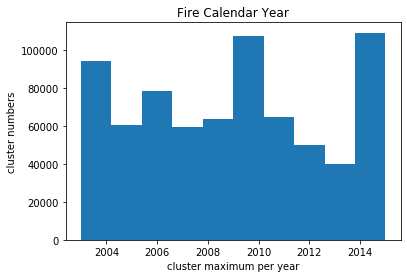

In [12]:
# Visualize the cluster_reference distribution by year
fig, ax = plt.subplots()
ax.hist(comdata['year'], bins=10, range = (comdata['year'].min(),comdata['year'].max()))
plt.title('Fire Calendar Year')
plt.xlabel('cluster maximum per year')
plt.ylabel('cluster numbers')
plt.show()

In [13]:
# Creating a variable to toggle/limit the dataset to one year within the boundaries of CONUS
comdata2015 = comdata[(comdata.year == 2015) & (comdata.latitude > 25) & (comdata.longitude < -67)]
comdata2015[1:2]

,Unnamed: 0,year,cluster_reference,cluster_doy,doy_count,centerpoint_doy,longitude,latitude
671709,697274,2015,2015_0,200,8,203.0,-124.5838,48.3398


In [14]:
# Checking data shape for variable year of 2015 and CONUS
comdata2015.shape

(56158, 8)

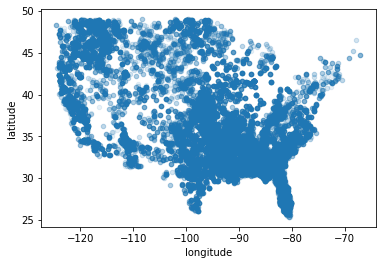

In [15]:
# Using comdata2015 for geographical depiction of fire clusters within CONUS
comdata2015.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

In [16]:
# Creating a variable to toggle/limit the dataset to one year within the boundaries of California 
comdata2015_ca = comdata[(comdata.year == 2015) & (comdata.latitude > 34) & (comdata.longitude < -114)]
comdata2015_ca[1:2]

,Unnamed: 0,year,cluster_reference,cluster_doy,doy_count,centerpoint_doy,longitude,latitude
671709,697274,2015,2015_0,200,8,203.0,-124.5838,48.3398


In [17]:
# Checking data shape for variable year of 2015 and for state of CA
comdata2015_ca.shape

(8220, 8)

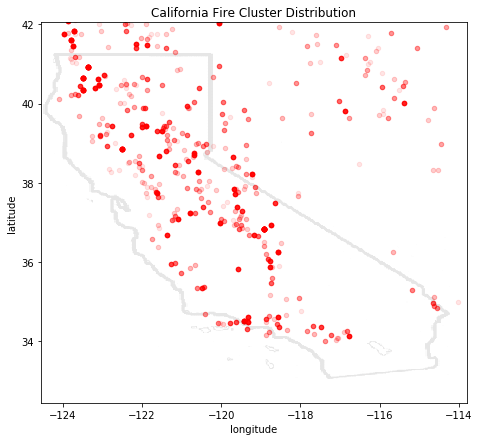

In [18]:
# California Fire Distribution Map
import matplotlib.image as mpimg
california_img=mpimg.imread('CaliforniaMapOutline.gif')
comdata2015_ca.plot(kind="scatter", x="longitude", y="latitude", c= "red", figsize=(10,7), alpha=0.1)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.1)
plt.title('California Fire Cluster Distribution') 
plt.show()